# **IMPORT FORMATTED DATA**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
original_path = "/content/drive/MyDrive/Colab Notebooks/data.txt"
text = open(original_path)
text = text.readlines()
data = ""
for i in text:
  data += i
print(data)


Basic Notes
Anng
10/9/12
Study Tips
- Prepare before class
  - Review notes from last class
  - Look through chapter to understand basic idea of this class
  - May take 20-30 mins but makes a huge difference
- When in doubt, write it down
  - Point: write everything through Main Points Main Ideas
  - Don't spend too long deciding if you should write down
- Thin your notes
  - Don't write everything. Leave out words.
  - Use abbreviations - include a key of specific-for-this lecture abbreviations. e.g., A lecture about King Henry VIII will require you to repeat his name several times. Instead of writing it out each time, make a note: King Henry 
VIII = H8. For that would be confused with King Henry VII, abbreviate it as King Henry VIII = 8.
- Know your prof
  - Use the note-taking method that will best help you with this particular prof's lectures.
  - A more organized prof works well with the Cornell style. Use the note-taking method for visual learners for a prof that jumps around and

# **DATA PROCESSING**

In [ ]:
def replace_bullet_points(text):
    indent = 0
    space = 0
    replaced_lines = []
    for i in text:
      if i == "-":
          # Replace the leading spaces with dashes
          text = text.replace(' ', '-', space)
          replaced_lines.append(text)
      elif i == " ":
          space += 1
      else:
        break
    return '\n'.join(replaced_lines)

In [ ]:
text_filename = "transformed_text.txt"
with open(text_filename, "w") as file:
  for line in text:
      if line.strip().startswith('-'):
        new_line = replace_bullet_points(line)
        file.write(new_line)
      else:
        file.write(line)

transformed_text.txt

```
Basic Notes
Anng
10/9/12
Study Tips
- Prepare before class
--- Review notes from last class
--- Look through chapter to understand basic idea of this class
--- May take 20-30 mins but makes a huge difference
- When in doubt, write it down
--- Point: write everything through Main Points Main Ideas
--- Don't spend too long deciding if you should write down
- Thin your notes
--- Don't write everything. Leave out words.
--- Use abbreviations - include a key of specific-for-this lecture abbreviations. e.g., A lecture about King Henry VIII will require you to repeat his name several times. Instead of writing it out each time, make a note: King Henry
VIII = H8. For that would be confused with King Henry VII, abbreviate it as King Henry VIII = 8.
- Know your prof
--- Use the note-taking method that will best help you with this particular prof's lectures.
--- A more organized prof works well with the Cornell style. Use the note-taking method for visual learners for a prof that jumps around and returns to previous points.
- Show the prof your notes after the first lecture and ask if you are hitting main points.
```



# **SPARK NLP MODEL**

In [ ]:
!pip install spark-nlp
!pip install pyspark

In [ ]:
import sparknlp
# Start Spark Session
spark = sparknlp.start()

In [ ]:
# Import the required modules and classes
from sparknlp.base import DocumentAssembler, Pipeline, LightPipeline
from sparknlp.annotator import (
    SentenceDetector,
    Tokenizer,
    YakeKeywordExtraction
)
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

# Step 1: Transforms raw texts to `document` annotation
document = DocumentAssembler() \
            .setInputCol("text") \
            .setOutputCol("document")
# Step 2: Sentence Detection
sentenceDetector = SentenceDetector() \
            .setInputCols("document") \
            .setOutputCol("sentence")
# Step 3: Tokenization
token = Tokenizer() \
            .setInputCols("sentence") \
            .setOutputCol("token") \
            .setContextChars(["(", ")", "?", "!", ".", ","])
# Step 4: Keyword Extraction
keywords = YakeKeywordExtraction() \
            .setInputCols("token") \
            .setOutputCol("keywords") \

# Define the pipeline
yake_pipeline = Pipeline(stages=[document, sentenceDetector, token, keywords])
# Create an empty dataframe
empty_df = spark.createDataFrame([['']]).toDF("text")
# Fit the dataframe to get the
yake_Model = yake_pipeline.fit(empty_df)

In [ ]:
import pandas as pd
import re
from IPython.core.display import display, HTML

In [ ]:
def highlight(text, keywords):
    for k in keywords:
        text = (re.sub(r'(\b%s\b)'%k, r'<span style="background-color: yellow;">\1</span>', text, flags=re.IGNORECASE))
    return text
highlight_udf = F.udf(highlight, StringType())

In [ ]:
df = spark.read.text(text_filename)
df = df.withColumnRenamed("value", "text")
df.show()

+--------------------+
|                text|
+--------------------+
|         Basic Notes|
|                Anng|
|             10/9/12|
|          Study Tips|
|- Prepare before ...|
|--- Review notes ...|
|--- Look through ...|
|--- May take 20-3...|
|- When in doubt, ...|
|--- Point: write ...|
|--- Don't spend t...|
|   - Thin your notes|
|--- Don't write e...|
|--- Use abbreviat...|
|VIII = H8. For th...|
|    - Know your prof|
|--- Use the note-...|
|--- A more organi...|
|- Show the prof y...|
+--------------------+



In [ ]:
result = yake_pipeline.fit(df).transform(df)
result = result.withColumn('unique_keywords', F.array_distinct("keywords.result"))
result= result.withColumn("highlighted_keywords",highlight_udf('text','unique_keywords'))

In [ ]:
file_path = "output.html"
with open(file_path, "w") as file:
  curr_num = 0
  prev_num = 0
  fixed_distance = 0

  for r in result.select("highlighted_keywords").collect():
    line_str = str(r.highlighted_keywords)

    if line_str.startswith("-"):
      for i in line_str:
        if i == "-":
          curr_num += 1
        else:
          break

      if curr_num == prev_num:
        line_str = line_str.replace("-", "", curr_num)
        line_str = "<li>" + line_str + "</li>"
        file.write(HTML(line_str).data)

      elif curr_num > prev_num:
        fixed_distance = curr_num - prev_num
        file.write("<ul>")
        line_str = line_str.replace("-", "", curr_num)
        line_str = "<li>" + line_str + "</li>"
        file.write(HTML(line_str).data)


      else:
        distance = prev_num - curr_num
        while distance >= fixed_distance:
          file.write("</ul>")
          distance -= 1
        line_str = line_str.replace("-", "", curr_num)
        line_str = "<li>" + line_str + "</li>"
        file.write(HTML(line_str).data)

      prev_num = curr_num
      curr_num = 0

    else:
      while prev_num > 0:
        file.write("</ul>")
        prev_num -= 1

      file.write("<p>")
      file.write(HTML(line_str).data)
      file.write("</p>")


output.html

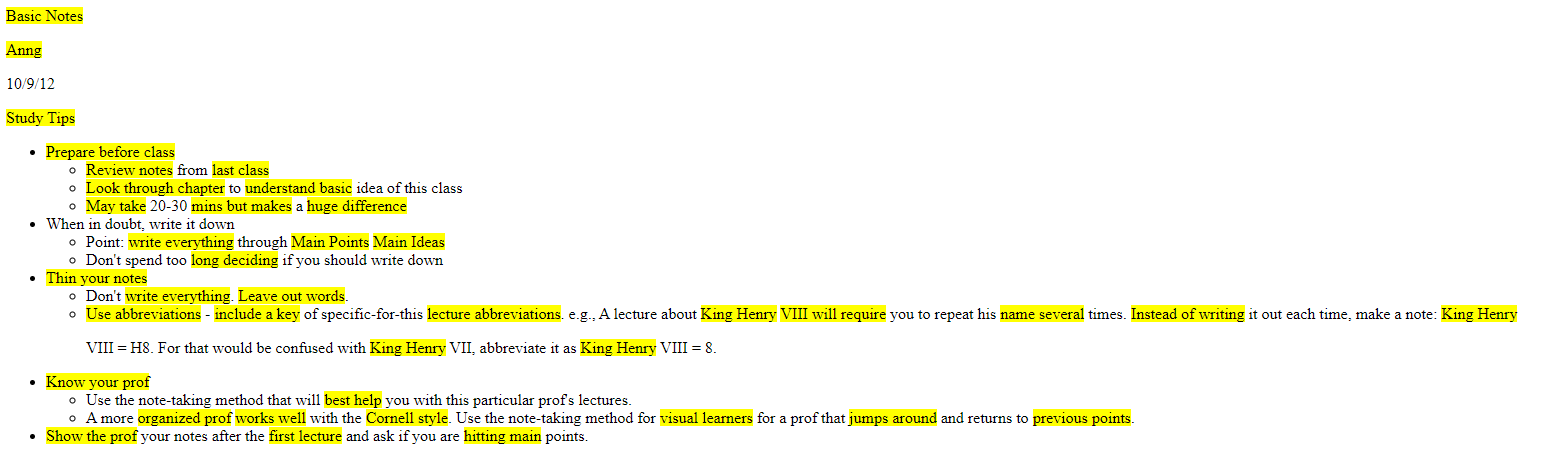
